## Load datasets

load the two CSV files:
- `original_preprocess.csv` (ORAN dataset)
- `dataset_ul.csv` (UL dataset)

also print their shapes to understand the dataset size.

In [239]:
import pandas as pd

oran = pd.read_csv("origin_data/original_preprocess.csv")
ul = pd.read_csv("origin_data/dataset_ul.csv")

In [240]:
print("ORAN raw shape:", oran.shape)
print("UL raw shape  :", ul.shape)

ORAN raw shape: (17501, 39)
UL raw shape  : (20018, 40)


In [241]:
oran.head()
oran.shape
oran.columns

Index(['date', 'BW', 'TM', 'traffic_load_dl', 'traffic_load_ul', 'txgain_dl',
       'txgain_ul', 'selected_mcs_dl', 'selected_mcs_ul',
       'selected_airtime_dl', 'selected_airtime_ul', 'mean_used_mcs_dl',
       'mean_used_mcs_ul', 'bsr_dl', 'bsr_ul', 'gput_ul', 'mean_snr_ul',
       'turbodec_it', 'dec_time', 'nRBs_ul', 'num_ues', 'thr_dl', 'thr_ul',
       'bler_dl', 'bler_ul', 'tbs_dl', 'pm_power', 'pm_var', 'pm_median',
       'n_pm', 'rapl_power', 'rapl_var', 'n_rapl', 'clockspeed', 'airtime_dl',
       'airtime_ul', 'cqi_dl', 'cqi_ul', 'fixed_mcs_flag'],
      dtype='object')

In [242]:
oran.isna().sum()
oran = oran.dropna()
oran = oran[oran["pm_power"] > 0]

In [243]:
ul.shape
ul.columns

Index(['date', 'cpu_platform', 'BW', 'TM', 'UL/DL', 'traffic_load', 'txgain',
       'cpu_time', 'number_active_cores', 'pinning', 'cpu_config',
       'selected_mcs', 'selected_airtime', 'mean_used_mcs', 'bsr', 'num_ues',
       'thr', 'gput', 'mean_snr', 'var_snr', 'bler', 'turbodec_it',
       'rssi_mean', 'rssi_var', 'overflows', 'underflows', 'lates', 'dec_time',
       'pm_power', 'pm_var', 'n_pm', 'rapl_power', 'rapl_var', 'n_rapl',
       'clockspeed', 'nRBs', 'airtime', 'num_subsamples', 'fixed_mcs_flag',
       'failed_experiment'],
      dtype='object')

In [244]:
ul.isna().sum()
ul = ul.dropna()
ul = ul[ul["rapl_power"] > 0]

## Define target and common features

To enable fair comparison and transfer learning, choosing a small set of robust common features that exist in both datasets, which can be mapped easily.

Target variable:
- predict **pm_power** (power meter measurement).  

Selected common features (input X):
- selected_airtime
- selected_mcs
- txgain


This results in a compact aligned dataset with 5 input features and 1 target column.


In [245]:
TARGET = "pm_power"

COMMON_FEATURES = [
    "airtime",
    "selected_mcs",
    "txgain"

]


## ORAN preprocessing and alignment

The ORAN dataset contains separate UL/DL columns (e.g., `airtime_ul`, `traffic_load_ul`).
Since this project focuses on uplink behaviour, extract the UL-related columns and rename them into a shared naming scheme.

Steps:
1) Select the relevant UL columns and the target column.
2) Rename the UL columns (e.g., `airtime_ul` → `airtime`) to match the UL dataset.
3) Convert all selected columns to numeric format.
4) Remove rows with missing values and invalid target values (power ≤ 0).

The output is a cleaned ORAN table with the same column names as the UL table.


In [246]:

oran_colmap = {
    "airtime_ul": "airtime",
    "selected_mcs_ul": "selected_mcs",
    "txgain_ul":"txgain",

    TARGET: TARGET  
}

oran_needed_cols = list(oran_colmap.keys())


oran = oran[oran_needed_cols].copy()
oran = oran.rename(columns=oran_colmap)

for c in COMMON_FEATURES + [TARGET]:
    oran[c] = pd.to_numeric(oran[c], errors="coerce")

oran = oran.dropna(subset=COMMON_FEATURES + [TARGET])
oran = oran[oran[TARGET] > 0]

print("✅ ORAN cleaned shape:", oran.shape)

✅ ORAN cleaned shape: (17501, 4)


## UL preprocessing

The UL dataset only contains ULrecords, and may include failed experiments.

Steps:
1) Filter to keep **UL** records only (`UL/DL == "UL"`).
2) Remove failed experiments (`failed_experiment == 0`).
3) Keep only the selected common features and the target column.
4) Convert selected columns to numeric format.
5) Remove missing values and invalid target values (power ≤ 0).

The output is a cleaned UL table with the same columns as the ORAN table.


In [247]:

# 1) Only retain UL (if there is a UL/DL column)
if "UL/DL" in ul.columns:
    ul = ul[ul["UL/DL"] == "UL"].copy()

# 2) Only filter the conditions：BW=50, traffic_load=24
ul = ul[
    (ul["BW"] == 50) &
    (ul["traffic_load"] == 24)
].copy()

# 3) Column name mapping (alignment ORAN/cam-ready)
ul_colmap = {
    "selected_airtime": "airtime",
    "selected_mcs": "selected_mcs",
    "txgain": "txgain",
    TARGET: TARGET
}

ul_needed_cols = list(ul_colmap.keys())

ul = ul[ul_needed_cols].copy()
ul = ul.rename(columns=ul_colmap)

# 4) numeric clean
for c in COMMON_FEATURES + [TARGET]:
    ul[c] = pd.to_numeric(ul[c], errors="coerce")

ul = ul.dropna(subset=COMMON_FEATURES + [TARGET])
ul = ul[ul[TARGET] > 0]

# 5) airtime is rounded to one decimal 
ul["airtime"] = ul["airtime"].round(1)

print("✅ UL cleaned shape:", ul.shape)
print("UL columns:", ul.columns.tolist())


✅ UL cleaned shape: (9396, 4)
UL columns: ['airtime', 'selected_mcs', 'txgain', 'pm_power']


In [248]:


# (1) ORAN：4 columns（input + output）
oran_4cols = oran[COMMON_FEATURES + [TARGET]].copy()

# (2) UL: Conditional Table（BW, traffic_load + input + output）
ul_with_cond = ul.copy()
ul_with_cond.insert(0, "traffic_load", 24)
ul_with_cond.insert(0, "BW", 50)

# (3) UL: A 4-column table without conditions（input + output）
ul_4cols = ul[COMMON_FEATURES + [TARGET]].copy()

# =========================
# 7) Print the information of 2 tables
# =========================

print("\n=== ORAN 4-column table ===")
print("shape:", oran_4cols.shape)
print("columns:", oran_4cols.columns.tolist())
print(oran_4cols.head())

print("\n=== UL 4-column table ===")
print("shape:", ul_4cols.shape)
print("columns:", ul_4cols.columns.tolist())
print(ul_4cols.head())

# =========================
# 8) Column alignment check
# =========================
print("\n=== Column alignment check ===")
print("ORAN columns:", oran_4cols.columns.tolist())
print("UL columns  :", ul_4cols.columns.tolist())

assert oran_4cols.columns.tolist() == ul_4cols.columns.tolist(), \
    "❌ ORAN and UL 4-column tables are not aligned!"

print("✅ ORAN and UL column alignment confirmed.")

# =========================
# 9) SAVE CSV
# =========================
oran_4cols.to_csv("clean_oran_stage1.csv", index=False)
ul_with_cond.to_csv("clean_ul_with_conditions.csv", index=False)
ul_4cols.to_csv("clean_ul_stage1.csv", index=False)

print("\n🎉 Saved files:")
print(" - clean_oran_stage1.csv")
print(" - clean_ul_with_conditions.csv")
print(" - clean_ul_stage1.csv")



=== ORAN 4-column table ===


shape: (17501, 4)
columns: ['airtime', 'selected_mcs', 'txgain', 'pm_power']
   airtime  selected_mcs  txgain   pm_power
0      1.0             0      74  13.648015
1      1.0             5      74  13.293121
2      1.0             9      74  13.384308
3      1.0            14      74  13.923219
4      1.0            18      74  14.150091

=== UL 4-column table ===
shape: (9396, 4)
columns: ['airtime', 'selected_mcs', 'txgain', 'pm_power']
   airtime  selected_mcs  txgain  pm_power
0      1.0            23      74  13.05631
1      0.9            23      74  13.10550
2      0.8            23      74  12.64807
3      0.7            23      74  11.71501
4      0.6            23      74  12.58539

=== Column alignment check ===
ORAN columns: ['airtime', 'selected_mcs', 'txgain', 'pm_power']
UL columns  : ['airtime', 'selected_mcs', 'txgain', 'pm_power']
✅ ORAN and UL column alignment confirmed.

🎉 Saved files:
 - clean_oran_stage1.csv
 - clean_ul_with_conditions.csv
 - clean_ul_stage1.csv

## Visualisation: Power distribution (UL)

Plot the histogram of the target power variable to understand:
- Typical power range
- Whether the distribution is unimodal or multi-modal
- Whether there are abnormal values

A multi-modal distribution can indicate multiple operating regimes (e.g., different system configurations).


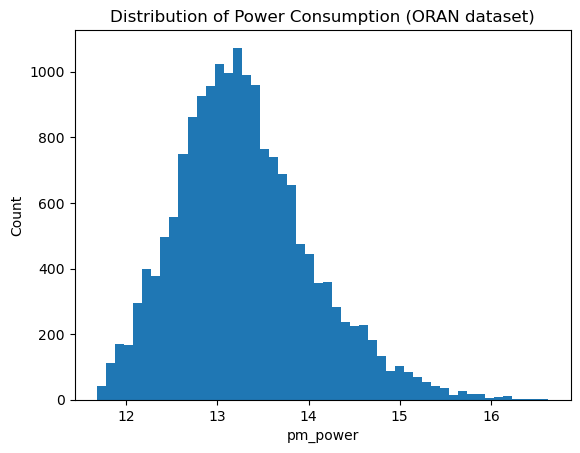

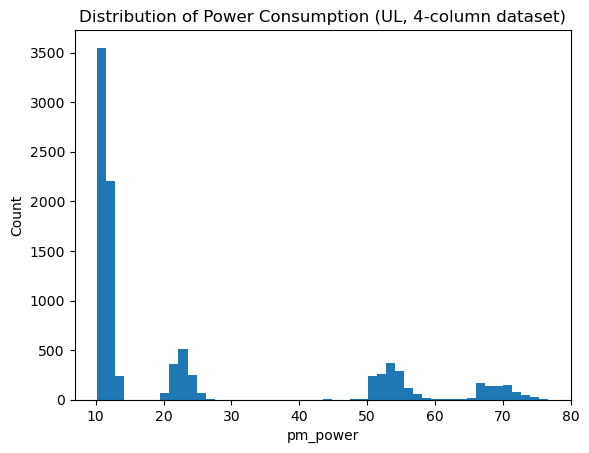

In [249]:

import matplotlib.pyplot as plt

plt.figure()
plt.hist(oran_4cols[TARGET], bins=50)
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.title("Distribution of Power Consumption (ORAN dataset)")
plt.show()


plt.figure()
plt.hist(ul_4cols[TARGET], bins=50)
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.title("Distribution of Power Consumption (UL, 4-column dataset)")
plt.show()





##  Visualisation: Power vs Airtime 

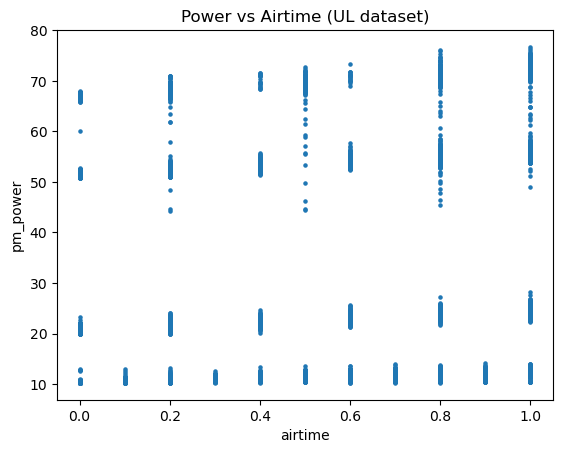

<function matplotlib.pyplot.show(close=None, block=None)>

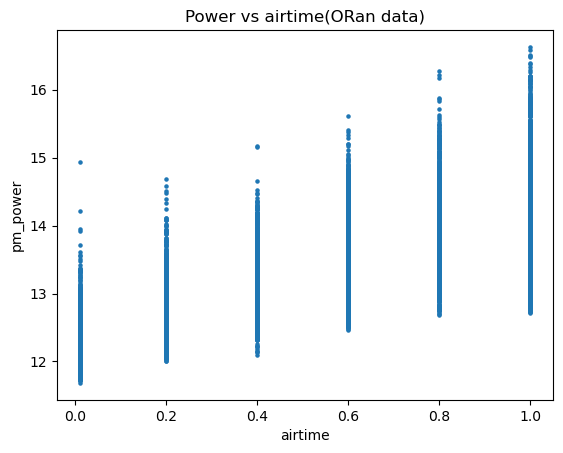

In [250]:
plt.figure()
plt.scatter(ul["airtime"], ul[TARGET], s=5)
plt.xlabel("airtime")
plt.ylabel(TARGET)
plt.title("Power vs Airtime (UL dataset)")
plt.show()

plt.figure()
plt.scatter(oran["airtime"],oran[TARGET],s=5)
plt.xlabel("airtime")
plt.ylabel(TARGET)
plt.title("Power vs airtime(ORan data)")
plt.show


##  Visualisation: Power vs Selected MCS 

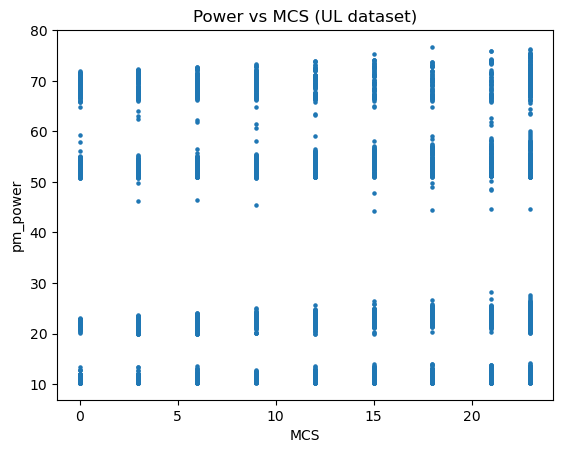

<function matplotlib.pyplot.show(close=None, block=None)>

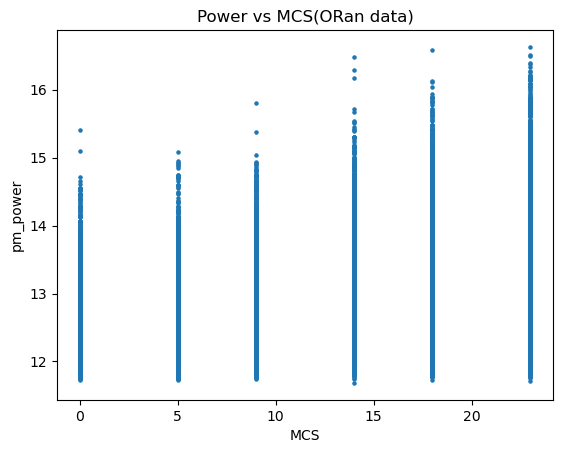

In [251]:
plt.figure()
plt.scatter(ul["selected_mcs"], ul[TARGET], s=5)
plt.xlabel("MCS")
plt.ylabel(TARGET)
plt.title("Power vs MCS (UL dataset)")
plt.show()

plt.figure()
plt.scatter(oran["selected_mcs"],oran[TARGET],s=5)
plt.xlabel("MCS")
plt.ylabel(TARGET)
plt.title("Power vs MCS(ORan data)")
plt.show

##  Visualisation: Power vs Txgain 

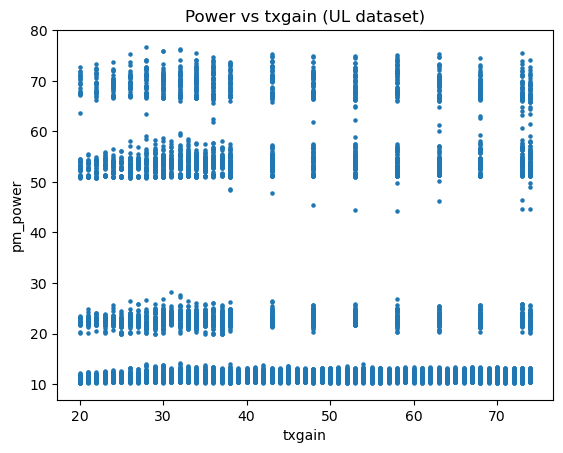

<function matplotlib.pyplot.show(close=None, block=None)>

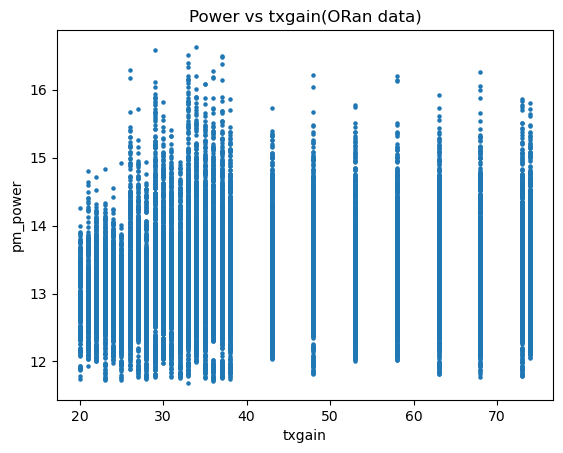

In [252]:
plt.figure()
plt.scatter(ul["txgain"], ul[TARGET], s=5)
plt.xlabel("txgain")
plt.ylabel(TARGET)
plt.title("Power vs txgain (UL dataset)")
plt.show()

plt.figure()
plt.scatter(oran["txgain"],oran[TARGET],s=5)
plt.xlabel("txgain")
plt.ylabel(TARGET)
plt.title("Power vs txgain(ORan data)")
plt.show

## Visualisation: ORAN vs UL power distribution comparison

Compare the target power distributions across ORAN and UL datasets.
If the distributions differ, this indicates a dataset shift between data sources.

A clear distribution shift motivates transfer learning:
- The task is the same (predict power)
- Feature semantics are aligned
- But the data distributions differ across domains


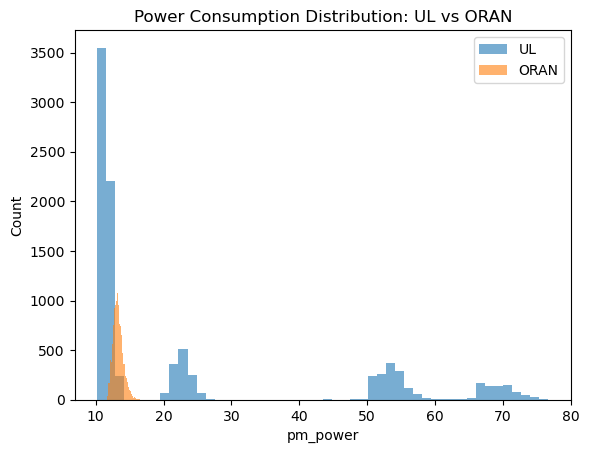

In [253]:
plt.figure()
plt.hist(ul_4cols[TARGET], bins=50, alpha=0.6, label="UL")
plt.hist(oran_4cols[TARGET], bins=50, alpha=0.6, label="ORAN")
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.title("Power Consumption Distribution: UL vs ORAN")
plt.legend()
plt.show()


## Summary 

In Stage 1, cleaned and aligned two independent datasets into a shared feature space consisting of a small set of common features and one power target variable. 

Basic visualisations show:
- The target power distribution in UL is multi-modal, suggesting different operating regimes.
- The relationship between airtime and power is not purely linear.
- ORAN and UL have different power distributions, indicating a distribution shift.

These observations motivate the use of machine learning and transfer learning in the next stages.

In [ ]:
import pandas as pd

# Count the airtime coverage for each (selected_mcs, txgain)
airtime_stats = (
    ul_4cols
    .groupby(["selected_mcs", "txgain"])["airtime"]
    .agg(
        num_samples="count",
        num_airtime="nunique",
        min_airtime="min",
        max_airtime="max"
    )
    .reset_index()
)

# Define "qualified candidates" : airtime has sufficient coverage and a wide enough scope
airtime_candidates = airtime_stats[
    (airtime_stats["num_airtime"] >= 8) &     # At least 8 airtime slots
    (airtime_stats["min_airtime"] <= 0.1) &
    (airtime_stats["max_airtime"] >= 0.9)
].copy()

# Sort by "number of airtime slots + number of samples" and select the best one
airtime_candidates = airtime_candidates.sort_values(
    ["num_airtime", "num_samples"],
    ascending=[False, False]
)

print("=== Fig.1 best candidates (top 10) ===")
print(airtime_candidates.head(10))


best_mcs   = airtime_candidates.iloc[0]["selected_mcs"]
best_gain  = airtime_candidates.iloc[0]["txgain"]

print(f"✅ Best Fig.1 fixed condition: selected_mcs={best_mcs}, txgain={best_gain}")


=== Fig.1 best candidates (top 10) ===
     selected_mcs  txgain  num_samples  num_airtime  min_airtime  max_airtime
452            23      32           57           11          0.0          1.0
454            23      34           57           11          0.0          1.0
456            23      36           57           11          0.0          1.0
458            23      38           57           11          0.0          1.0
463            23      43           57           11          0.0          1.0
468            23      48           57           11          0.0          1.0
473            23      53           57           11          0.0          1.0
478            23      58           57           11          0.0          1.0
483            23      63           57           11          0.0          1.0
488            23      68           57           11          0.0          1.0
✅ Best Fig.1 fixed condition: selected_mcs=23.0, txgain=32.0


In [255]:
txgain_stats = (
    ul_4cols
    .groupby(["airtime", "selected_mcs"])["txgain"]
    .agg(
        num_samples="count",
        num_txgain="nunique"
    )
    .reset_index()
)

txgain_candidates = txgain_stats[txgain_stats["num_txgain"] >= 3] \
    .sort_values(["num_txgain", "num_samples"], ascending=[False, False])

print("\n=== Fig.2 best candidates (top 10) ===")
print(txgain_candidates.head(10))

best_mcs   = txgain_candidates.iloc[0]["selected_mcs"]
best_airtime  = txgain_candidates.iloc[0]["airtime"]

print(f"✅ Best Fig.2 fixed condition: selected_mcs={best_mcs}, airtime={best_airtime}")



=== Fig.2 best candidates (top 10) ===
    airtime  selected_mcs  num_samples  num_txgain
80      0.8            23          215          55
8       0.0            23          214          55
26      0.2            23          214          55
98      1.0            23          214          55
62      0.6            23          202          55
44      0.4            23          200          55
1       0.0             3          127          55
2       0.0             6          127          55
19      0.2             3          127          55
20      0.2             6          127          55
✅ Best Fig.2 fixed condition: selected_mcs=23.0, airtime=0.8


In [256]:
mcs_stats = (
    ul_4cols
    .groupby(["airtime", "txgain"])["selected_mcs"]
    .agg(
        num_samples="count",
        num_mcs="nunique"
    )
    .reset_index()
)

mcs_candidates = mcs_stats[mcs_stats["num_mcs"] >= 3] \
    .sort_values(["num_mcs", "num_samples"], ascending=[False, False])

print("\n=== Fig.3 best candidates (top 10) ===")
print(mcs_candidates.head(10))

best_gain  = mcs_candidates.iloc[0]["txgain"]
best_airtime  = mcs_candidates.iloc[0]["airtime"]

print(f"✅ Best Fig.3 fixed condition: airtime={best_airtime}, txgain={best_gain}")



=== Fig.3 best candidates (top 10) ===
     airtime  txgain  num_samples  num_mcs
33       0.0      53           40        9
38       0.0      58           40        9
43       0.0      63           40        9
48       0.0      68           40        9
53       0.0      73           40        9
54       0.0      74           40        9
138      0.2      48           40        9
143      0.2      53           40        9
148      0.2      58           40        9
153      0.2      63           40        9
✅ Best Fig.3 fixed condition: airtime=0.0, txgain=53.0


    airtime   pm_power
0       0.0  37.657565
1       0.1  10.836005
2       0.2  38.412869
3       0.3  11.059060
4       0.4  35.612527
5       0.5  32.003767
6       0.6  36.240529
7       0.7  12.169990
8       0.8  42.069401
9       0.9  13.230015
10      1.0  42.817231


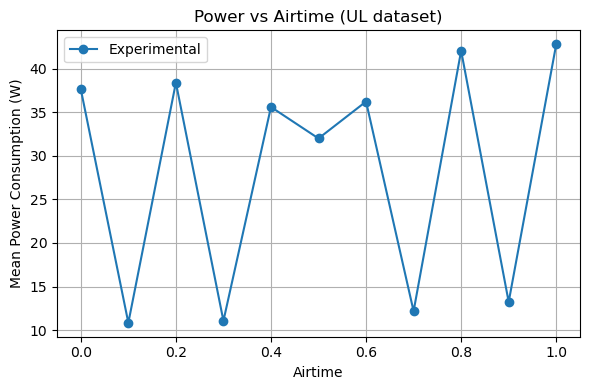

In [257]:
selected_mcs = 23
txgain = 32

df_f5 = ul_4cols[
    (ul_4cols["selected_mcs"] == 23) &
    (ul_4cols["txgain"] == 32)
]

df_plot = df_f5.groupby("airtime")["pm_power"].mean().reset_index()

df_f5_mean = (
    df_f5
    .groupby("airtime")["pm_power"]
    .mean()
    .reset_index()
    .sort_values("airtime")
)

print(df_f5_mean)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

plt.plot(
    df_f5_mean["airtime"],
    df_f5_mean["pm_power"],
    marker="o",
    linestyle="-",
    label="Experimental"
)

plt.xlabel("Airtime")
plt.ylabel("Mean Power Consumption (W)")
plt.title("Power vs Airtime (UL dataset)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()





    txgain   pm_power
0       20  32.440018
1       21  15.245003
2       22  33.739880
3       23  14.711920
4       24  33.504064
5       25  15.756653
6       26  33.907970
7       27  15.437207
8       28  34.321964
9       29  15.297327
10      30  40.013438
11      31  17.850600
12      32  42.069401
13      33  26.766944
14      34  40.641900
15      35  25.709364
16      36  41.615292
17      37  25.496620
18      38  41.022500
19      39  12.362450
20      40  12.649865
21      41  12.404085
22      42  12.540455
23      43  41.606661
24      44  13.007350
25      45  13.136515
26      46  12.721975
27      47  12.760840
28      48  41.161050
29      49  12.970290
30      50  12.271805
31      51  12.751790
32      52  12.320040
33      53  41.703220
34      54  12.387470
35      55  12.833670
36      56  12.680945
37      57  12.950735
38      58  41.750144
39      59  12.819080
40      60  12.777195
41      61  12.648660
42      62  12.814020
43      63  41.756287
44      64

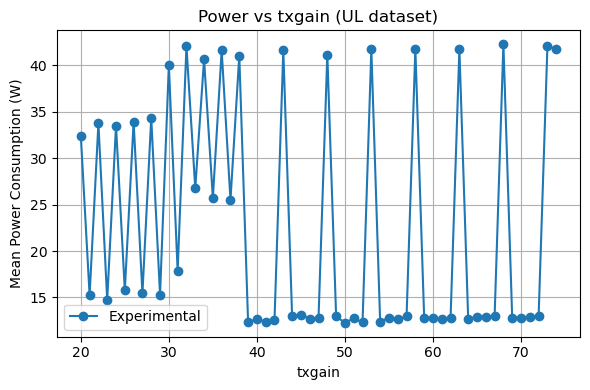

In [258]:
selected_mcs = 23
airtime = 0.8

df_f1 = ul_4cols[
    (ul_4cols["selected_mcs"] == 23) &
    (ul_4cols["airtime"] == 0.8)
]

df_plot = df_f1.groupby("txgain")["pm_power"].mean().reset_index()

df_f1_mean = (
    df_f1
    .groupby("txgain")["pm_power"]
    .mean()
    .reset_index()
    .sort_values("txgain")
)

print(df_f1_mean)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

plt.plot(
    df_f1_mean["txgain"],
    df_f1_mean["pm_power"],
    marker="o",
    linestyle="-",
    label="Experimental"
)

plt.xlabel("txgain")
plt.ylabel("Mean Power Consumption (W)")
plt.title("Power vs txgain (UL dataset)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()





   selected_mcs   pm_power
0             0  42.983627
1             3  37.148938
2             6  38.062055
3             9  37.570427
4            12  37.511643
5            15  37.541195
6            18  37.409472
7            21  37.745090
8            23  37.657565


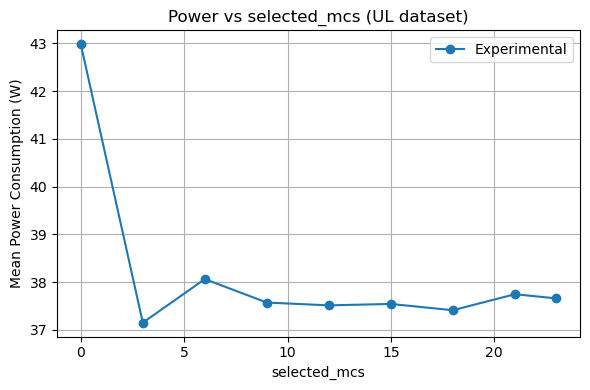

In [259]:
airtime = 0.0
txgain = 53

df_f4 = ul_4cols[
    (ul_4cols["airtime"] == 0.0) &
    (ul_4cols["txgain"] == 32)
]

df_plot = df_f4.groupby("selected_mcs")["pm_power"].mean().reset_index()

df_f4_mean = (
    df_f4
    .groupby("selected_mcs")["pm_power"]
    .mean()
    .reset_index()
    .sort_values("selected_mcs")
)

print(df_f4_mean)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

plt.plot(
    df_f4_mean["selected_mcs"],
    df_f4_mean["pm_power"],
    marker="o",
    linestyle="-",
    label="Experimental"
)

plt.xlabel("selected_mcs")
plt.ylabel("Mean Power Consumption (W)")
plt.title("Power vs selected_mcs (UL dataset)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



